<a href="https://colab.research.google.com/github/b-akash-krishna/trance-project/blob/main/trance_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================================
# CELL 1: Setup & Configuration
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import requests
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Create project structure
def create_project():
    dirs = ['data/raw', 'data/processed', 'data/embeddings', 'outputs/models',
            'outputs/figures', 'outputs/results', 'configs']
    for d in dirs:
        Path(d).mkdir(parents=True, exist_ok=True)

    config = {
        "project": {"name": "TRANCE", "version": "1.0.0"},
        "data": {
            "mimic_demo_url": "https://physionet.org/files/mimiciii-demo/1.4/",
            "cohort": {"min_age": 18, "min_los_hours": 24, "readmission_window_days": 30}
        },
        "model": {
            "embedding_model": "emilyalsentzer/Bio_ClinicalBERT",
            "embedding_dim": 768,
            "max_text_length": 512,
            "chunk_overlap": 128
        },
        "training": {
            "test_size": 0.2,
            "calibration_size": 0.1,
            "random_state": 42,
            "lgbm_params": {
                "objective": "binary", "metric": "auc", "boosting_type": "gbdt",
                "num_leaves": 7, "max_depth": 3, "learning_rate": 0.01,
                "n_estimators": 200, "min_child_samples": 10,
                "reg_alpha": 0.5, "reg_lambda": 0.5, "feature_fraction": 0.8,
                "bagging_fraction": 0.8, "bagging_freq": 5, "verbose": -1
            }
        },
        "paths": {
            "raw_data": "data/raw",
            "processed_data": "data/processed",
            "embeddings": "data/embeddings",
            "models": "outputs/models",
            "figures": "outputs/figures"
        }
    }

    with open('configs/config.json', 'w') as f:
        json.dump(config, f, indent=2)

    return config

config = create_project()
print("✓ Project initialized")

✓ Project initialized


In [ ]:
# ============================================================================
# CELL 2: Download MIMIC-III Demo Data
# ============================================================================
def download_mimic_data():
    base_url = "https://physionet.org/files/mimiciii-demo/1.4/"
    tables = ['ADMISSIONS.csv', 'PATIENTS.csv', 'DIAGNOSES_ICD.csv',
              'PROCEDURES_ICD.csv', 'PRESCRIPTIONS.csv', 'LABEVENTS.csv',
              'NOTEEVENTS.csv', 'ICUSTAYS.csv', 'D_ICD_DIAGNOSES.csv',
              'D_ICD_PROCEDURES.csv', 'D_LABITEMS.csv']

    data_dir = Path('data/raw')

    for table in tqdm(tables, desc="Downloading"):
        dest = data_dir / table
        if dest.exists():
            continue

        try:
            response = requests.get(base_url + table, stream=True)
            if response.status_code == 200:
                with open(dest, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
        except Exception as e:
            print(f"Failed {table}: {e}")

    print("✓ Data downloaded")

download_mimic_data()


Downloading: 100%|██████████| 11/11 [00:30<00:00,  2.81s/it]

✓ Data downloaded


In [ ]:
# ============================================================================
# CELL 3: Load & Preprocess Core Tables
# ============================================================================
data_dir = Path('data/raw')

# Load with uppercase columns
def load_table(filename):
    df = pd.read_csv(data_dir / filename)
    df.columns = df.columns.str.upper()
    return df

admissions = load_table('ADMISSIONS.csv')
patients = load_table('PATIENTS.csv')
diagnoses = load_table('DIAGNOSES_ICD.csv')
procedures = load_table('PROCEDURES_ICD.csv')
prescriptions = load_table('PRESCRIPTIONS.csv')
labevents = load_table('LABEVENTS.csv')
noteevents = load_table('NOTEEVENTS.csv')
icustays = load_table('ICUSTAYS.csv')
d_icd_diagnoses = load_table('D_ICD_DIAGNOSES.csv')
d_labitems = load_table('D_LABITEMS.csv')

# Convert dates
for col in ['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'EDREGTIME', 'EDOUTTIME']:
    if col in admissions.columns:
        admissions[col] = pd.to_datetime(admissions[col], errors='coerce')

patients['DOB'] = pd.to_datetime(patients['DOB'], errors='coerce')
patients['DOD'] = pd.to_datetime(patients['DOD'], errors='coerce')

print(f"✓ Loaded: {len(admissions)} admissions, {len(patients)} patients")

✓ Loaded: 129 admissions, 100 patients


In [ ]:
# ============================================================================
# CELL 4: Generate Discharge Summaries for Missing Notes
# ============================================================================
def generate_discharge_text(hadm_id, admissions_patients, diagnoses, procedures, prescriptions):
    row = admissions_patients[admissions_patients['HADM_ID'] == hadm_id].iloc[0]

    age = row.get('AGE', 'unknown')
    gender = 'male' if row.get('GENDER') == 'M' else 'female'
    admit_date = row.get('ADMITTIME').strftime('%Y-%m-%d') if pd.notna(row.get('ADMITTIME')) else 'unknown'
    los = round(row.get('LOS_DAYS', 0), 1)

    diag_codes = diagnoses[diagnoses['HADM_ID'] == hadm_id]['ICD9_CODE'].astype(str).tolist()
    diag_text = ", ".join(diag_codes[:10]) if diag_codes else "No diagnoses"

    proc_codes = procedures[procedures['HADM_ID'] == hadm_id]['ICD9_CODE'].astype(str).tolist()
    proc_text = ", ".join(proc_codes[:5]) if proc_codes else "No procedures"

    rx = prescriptions[prescriptions['HADM_ID'] == hadm_id]
    rx_list = [f"{r.get('DRUG', 'Unknown')} {r.get('DOSE_VAL_RX', '')} {r.get('DOSE_UNIT_RX', '')}"
               for _, r in rx.head(5).iterrows()]
    rx_text = "; ".join(rx_list) if rx_list else "No medications"

    return (f"Patient: {age}yo {gender}, admitted {admit_date}, {los}d stay. "
            f"Diagnoses: {diag_text}. Procedures: {proc_text}. "
            f"Medications: {rx_text}. Discharged to {row.get('DISCHARGE_LOCATION', 'home')}.")

# Merge and calculate features
admissions_patients = admissions.merge(patients[['SUBJECT_ID', 'DOB', 'DOD', 'GENDER']], on='SUBJECT_ID')
admissions_patients['AGE'] = admissions_patients['ADMITTIME'].dt.year - admissions_patients['DOB'].dt.year
admissions_patients['LOS_DAYS'] = (admissions_patients['DISCHTIME'] - admissions_patients['ADMITTIME']).dt.total_seconds() / 86400

# Update noteevents
for idx, row in admissions_patients.iterrows():
    hadm_id = row['HADM_ID']
    existing = noteevents[noteevents['HADM_ID'] == hadm_id]

    if len(existing) == 0 or existing['TEXT'].isna().all():
        text = generate_discharge_text(hadm_id, admissions_patients, diagnoses, procedures, prescriptions)

        if len(existing) == 0:
            new_row = {
                'ROW_ID': noteevents['ROW_ID'].max() + 1 if len(noteevents) > 0 else 1,
                'SUBJECT_ID': row['SUBJECT_ID'],
                'HADM_ID': hadm_id,
                'CHARTDATE': row['ADMITTIME'].strftime('%Y-%m-%d') if pd.notna(row['ADMITTIME']) else '',
                'CATEGORY': 'Discharge summary',
                'TEXT': text
            }
            noteevents = pd.concat([noteevents, pd.DataFrame([new_row])], ignore_index=True)
        else:
            noteevents.loc[noteevents['HADM_ID'] == hadm_id, 'TEXT'] = text
            noteevents.loc[noteevents['HADM_ID'] == hadm_id, 'CATEGORY'] = 'Discharge summary'

noteevents.to_csv(data_dir / 'NOTEEVENTS_with_discharge_text.csv', index=False)
print(f"✓ Generated discharge summaries: {len(noteevents)} notes")


✓ Generated discharge summaries: 129 notes


In [ ]:
# ============================================================================
# CELL 5: Define Cohort & Create Readmission Labels
# ============================================================================
cohort = admissions_patients.copy()

# Inclusion criteria
cohort = cohort[
    (cohort['AGE'] >= 18) &
    (cohort['LOS_DAYS'] >= 1) &
    (cohort['ADMISSION_TYPE'].isin(['EMERGENCY', 'URGENT'])) &
    (cohort['DISCHTIME'].notna())
]

# Exclusion: in-hospital mortality
cohort['HOSPITAL_MORTALITY'] = cohort['HOSPITAL_EXPIRE_FLAG'] == 1
cohort = cohort[~cohort['HOSPITAL_MORTALITY']]

# Sort and calculate readmission
cohort = cohort.sort_values(['SUBJECT_ID', 'ADMITTIME']).reset_index(drop=True)
cohort['NEXT_ADMITTIME'] = cohort.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)
cohort['DAYS_TO_NEXT_ADMIT'] = (cohort['NEXT_ADMITTIME'] - cohort['DISCHTIME']).dt.total_seconds() / 86400
cohort['TARGET_READMIT_30'] = (cohort['DAYS_TO_NEXT_ADMIT'] <= 30) & (cohort['DAYS_TO_NEXT_ADMIT'] > 0)
cohort['IS_LAST_ADMISSION'] = cohort['NEXT_ADMITTIME'].isna()

# Add discharge notes
discharge_notes = noteevents[noteevents['CATEGORY'] == 'Discharge summary'][['HADM_ID', 'TEXT']]
discharge_notes.columns = ['HADM_ID', 'DISCHARGE_TEXT']
cohort = cohort.merge(discharge_notes, on='HADM_ID', how='left')
cohort['HAS_DISCHARGE_NOTE'] = cohort['DISCHARGE_TEXT'].notna()

readmit_rate = cohort['TARGET_READMIT_30'].mean()
print(f"✓ Cohort: {len(cohort)} admissions, {readmit_rate:.2%} readmission rate")

# Save
cohort_cols = ['HADM_ID', 'SUBJECT_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE',
               'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'ETHNICITY',
               'AGE', 'GENDER', 'LOS_DAYS', 'TARGET_READMIT_30', 'DAYS_TO_NEXT_ADMIT',
               'IS_LAST_ADMISSION', 'HAS_DISCHARGE_NOTE', 'DISCHARGE_TEXT']
cohort[cohort_cols].to_parquet('data/processed/cohort_with_outcomes.parquet', index=False)


✓ Cohort: 79 admissions, 7.59% readmission rate


In [ ]:
# ============================================================================
# CELL 6: Comprehensive Feature Engineering
# ============================================================================
features = cohort[['HADM_ID', 'SUBJECT_ID']].copy()

# Demographics
features['age'] = cohort['AGE']
features['gender_M'] = (cohort['GENDER'] == 'M').astype(int)

def categorize_ethnicity(eth):
    if pd.isna(eth): return 'UNKNOWN'
    eth = eth.upper()
    if 'WHITE' in eth: return 'WHITE'
    if 'BLACK' in eth or 'AFRICAN' in eth: return 'BLACK'
    if 'HISPANIC' in eth or 'LATINO' in eth: return 'HISPANIC'
    if 'ASIAN' in eth: return 'ASIAN'
    return 'OTHER'

features['ethnicity_category'] = cohort['ETHNICITY'].apply(categorize_ethnicity)
features = pd.concat([features, pd.get_dummies(features['ethnicity_category'], prefix='ethnicity')], axis=1)
features = pd.concat([features, pd.get_dummies(cohort['INSURANCE'], prefix='insurance')], axis=1)

# Admission features
features['los_days'] = cohort['LOS_DAYS']
features['admit_weekend'] = (pd.to_datetime(cohort['ADMITTIME']).dt.dayofweek >= 5).astype(int)
features['discharge_weekend'] = (pd.to_datetime(cohort['DISCHTIME']).dt.dayofweek >= 5).astype(int)

# Diagnoses & comorbidities
diag_counts = diagnoses.groupby('HADM_ID').size().reset_index(name='n_diagnoses')
features = features.merge(diag_counts, on='HADM_ID', how='left').fillna({'n_diagnoses': 0})

def get_charlson(hadm_id):
    codes = diagnoses[diagnoses['HADM_ID'] == hadm_id]['ICD9_CODE'].astype(str).tolist()
    score = 0
    conditions = {'MI': ['410', '412'], 'CHF': ['428'], 'CVD': ['43'], 'COPD': ['49', '50'],
                  'Diabetes': ['250'], 'Renal': ['58'], 'Liver': ['571'], 'Cancer': ['14', '15', '16', '17', '18', '19', '20']}
    for cond_codes in conditions.values():
        if any(any(c.startswith(code) for code in cond_codes) for c in codes):
            score += 1
    return score

features['charlson_score'] = features['HADM_ID'].apply(get_charlson)

# High-risk diagnoses
def has_dx(hadm_id, prefixes):
    codes = diagnoses[diagnoses['HADM_ID'] == hadm_id]['ICD9_CODE'].astype(str).tolist()
    return int(any(any(c.startswith(p) for p in prefixes) for c in codes))

features['dx_heart_failure'] = features['HADM_ID'].apply(lambda x: has_dx(x, ['428']))
features['dx_copd'] = features['HADM_ID'].apply(lambda x: has_dx(x, ['49']))
features['dx_diabetes'] = features['HADM_ID'].apply(lambda x: has_dx(x, ['250']))
features['dx_renal_failure'] = features['HADM_ID'].apply(lambda x: has_dx(x, ['584', '585']))

# Procedures
proc_counts = procedures.groupby('HADM_ID').size().reset_index(name='n_procedures')
features = features.merge(proc_counts, on='HADM_ID', how='left').fillna({'n_procedures': 0})

# ICU
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'], errors='coerce')
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'], errors='coerce')
icustays['ICU_LOS'] = (icustays['OUTTIME'] - icustays['INTIME']).dt.total_seconds() / 86400

icu_agg = icustays.groupby('HADM_ID').agg({'ICUSTAY_ID': 'count', 'ICU_LOS': 'sum'}).reset_index()
icu_agg.columns = ['HADM_ID', 'n_icu_stays', 'total_icu_days']
features = features.merge(icu_agg, on='HADM_ID', how='left').fillna({'n_icu_stays': 0, 'total_icu_days': 0})
features['had_icu_stay'] = (features['n_icu_stays'] > 0).astype(int)

# Medications
med_counts = prescriptions.groupby('HADM_ID')['DRUG'].nunique().reset_index(name='n_medications')
features = features.merge(med_counts, on='HADM_ID', how='left').fillna({'n_medications': 0})

# Labs (last values before discharge)
labevents['CHARTTIME'] = pd.to_datetime(labevents['CHARTTIME'], errors='coerce')
labs_with_disch = labevents.merge(cohort[['HADM_ID', 'DISCHTIME']], on='HADM_ID')
labs_with_disch = labs_with_disch[labs_with_disch['CHARTTIME'] <= labs_with_disch['DISCHTIME']]
labs_with_disch = labs_with_disch.merge(d_labitems[['ITEMID', 'LABEL']], on='ITEMID', how='left')

key_labs = {'Creatinine': ['CREATININE'], 'Hemoglobin': ['HEMOGLOBIN', 'HGB'],
            'WBC': ['WBC'], 'Sodium': ['SODIUM'], 'Glucose': ['GLUCOSE']}

for lab_name, keywords in key_labs.items():
    lab_data = labs_with_disch[labs_with_disch['LABEL'].str.upper().str.contains('|'.join(keywords), na=False)]
    last_vals = lab_data.sort_values('CHARTTIME').groupby('HADM_ID').last()['VALUENUM'].reset_index()
    last_vals.columns = ['HADM_ID', f'lab_{lab_name.lower()}_last']
    features = features.merge(last_vals, on='HADM_ID', how='left')

# Prior admissions
def count_prior(row, window_days):
    return len(admissions[
        (admissions['SUBJECT_ID'] == row['SUBJECT_ID']) &
        (admissions['DISCHTIME'] < row['ADMITTIME']) &
        (admissions['DISCHTIME'] >= row['ADMITTIME'] - pd.Timedelta(days=window_days))
    ])

features['prior_admissions_180d'] = cohort.apply(lambda r: count_prior(r, 180), axis=1)
features['frequent_flyer'] = (features['prior_admissions_180d'] >= 3).astype(int)

# Handle missing labs
lab_cols = [c for c in features.columns if c.startswith('lab_')]
for col in lab_cols:
    features[f'{col}_missing'] = features[col].isna().astype(int)
    features[col] = features[col].fillna(features[col].median() if features[col].notna().sum() > 0 else 0)

# Drop categorical intermediates
features.drop(['ethnicity_category'], axis=1, errors='ignore', inplace=True)

# Add target
features['target_readmit_30'] = cohort['TARGET_READMIT_30'].astype(int)
features['is_last_admission'] = cohort['IS_LAST_ADMISSION'].astype(int)
features['has_discharge_note'] = cohort['HAS_DISCHARGE_NOTE'].astype(int)

# Ensure numeric
metadata_cols = ['HADM_ID', 'SUBJECT_ID', 'target_readmit_30', 'is_last_admission', 'has_discharge_note']
feature_cols = [c for c in features.columns if c not in metadata_cols]

for col in feature_cols:
    features[col] = pd.to_numeric(features[col], errors='coerce').fillna(0).astype(np.float64)

print(f"✓ Engineered {len(feature_cols)} features")


✓ Engineered 36 features


In [ ]:
# ============================================================================
# CELL 7: Create Train/Calib/Test Splits (Temporal)
# ============================================================================
features_with_time = features.merge(cohort[['HADM_ID', 'DISCHTIME']], on='HADM_ID')
features_with_time = features_with_time.sort_values('DISCHTIME')

evaluable = features_with_time[features_with_time['is_last_admission'] == 0].copy()

n_total = len(evaluable)
n_train = int(n_total * 0.7)
n_calib = int(n_total * 0.1)

train_data = evaluable.iloc[:n_train].drop('DISCHTIME', axis=1)
calib_data = evaluable.iloc[n_train:n_train+n_calib].drop('DISCHTIME', axis=1)
test_data = evaluable.iloc[n_train+n_calib:].drop('DISCHTIME', axis=1)

train_data.to_parquet('data/processed/train_features.parquet', index=False)
calib_data.to_parquet('data/processed/calibration_features.parquet', index=False)
test_data.to_parquet('data/processed/test_features.parquet', index=False)

with open('data/processed/feature_info.json', 'w') as f:
    json.dump({'feature_names': feature_cols, 'n_features': len(feature_cols)}, f, indent=2)

print(f"✓ Splits: Train={len(train_data)}, Calib={len(calib_data)}, Test={len(test_data)}")


✓ Splits: Train=14, Calib=2, Test=5


In [ ]:
# ============================================================================
# CELL 8: Generate Clinical Text Embeddings
# ============================================================================
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModel.from_pretrained(model_name).to(device).eval()

cohort_with_notes = cohort[cohort['HAS_DISCHARGE_NOTE'] & cohort['DISCHARGE_TEXT'].notna()].copy()
cohort_with_notes['PROCESSED_TEXT'] = cohort_with_notes['DISCHARGE_TEXT'].str.lower().str.strip()
cohort_with_notes = cohort_with_notes[cohort_with_notes['PROCESSED_TEXT'].str.len() >= 5]

@torch.no_grad()
def generate_embeddings(texts, batch_size=16, max_length=512):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch_texts = texts[i:i+batch_size]

        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)

        outputs = model(**encoded)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

texts = cohort_with_notes['PROCESSED_TEXT'].tolist()
embeddings = generate_embeddings(texts)

# Save
import h5py
with h5py.File('data/embeddings/discharge_note_embeddings.h5', 'w') as f:
    f.create_dataset('embeddings', data=embeddings, compression='gzip')

    # Convert HADM_IDs safely for HDF5 (works for both numeric and string IDs)
    hadm_ids = cohort_with_notes['HADM_ID'].astype(str).values.astype('S')
    f.create_dataset('hadm_ids', data=hadm_ids)

emb_df = pd.DataFrame(embeddings, columns=[f'emb_{i}' for i in range(embeddings.shape[1])])
emb_df['HADM_ID'] = cohort_with_notes['HADM_ID'].values
emb_df.to_parquet('data/embeddings/embeddings.parquet', index=False)

print(f"✓ Generated embeddings: {embeddings.shape}")

# Cleanup GPU
if torch.cuda.is_available():
    del model
    torch.cuda.empty_cache()


Using device: cpu


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]


Embedding: 100%|██████████| 5/5 [00:38<00:00,  7.73s/it]

✓ Generated embeddings: (79, 768)


In [ ]:
# ============================================================================
# CELL 9: Create Fused Features (Structured + Embeddings)
# ============================================================================
train_struct = pd.read_parquet('data/processed/train_features.parquet')
calib_struct = pd.read_parquet('data/processed/calibration_features.parquet')
test_struct = pd.read_parquet('data/processed/test_features.parquet')
embeddings_df = pd.read_parquet('data/embeddings/embeddings.parquet')

train_fused = train_struct.merge(embeddings_df, on='HADM_ID', how='left')
calib_fused = calib_struct.merge(embeddings_df, on='HADM_ID', how='left')
test_fused = test_struct.merge(embeddings_df, on='HADM_ID', how='left')

# Fill missing embeddings with zeros
embedding_cols = [c for c in embeddings_df.columns if c.startswith('emb_')]
for df in [train_fused, calib_fused, test_fused]:
    df[embedding_cols] = df[embedding_cols].fillna(0)

train_fused.to_parquet('data/processed/train_fused.parquet', index=False)
calib_fused.to_parquet('data/processed/calibration_fused.parquet', index=False)
test_fused.to_parquet('data/processed/test_fused.parquet', index=False)

print(f"✓ Fused features: {train_fused.shape}")


✓ Fused features: (14, 809)


In [ ]:
# ============================================================================
# CELL 10: Train Models (Baseline + Fused) with SHAP
# ============================================================================
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.isotonic import IsotonicRegression
import joblib

# Load data
train_struct = pd.read_parquet('data/processed/train_features.parquet')
calib_struct = pd.read_parquet('data/processed/calibration_features.parquet')
test_struct = pd.read_parquet('data/processed/test_features.parquet')
train_fused = pd.read_parquet('data/processed/train_fused.parquet')
calib_fused = pd.read_parquet('data/processed/calibration_fused.parquet')
test_fused = pd.read_parquet('data/processed/test_fused.parquet')

# Prepare features
struct_features = [c for c in train_struct.columns if c not in ['HADM_ID', 'SUBJECT_ID', 'target_readmit_30', 'is_last_admission', 'has_discharge_note']]
fused_features = [c for c in train_fused.columns if c not in ['HADM_ID', 'SUBJECT_ID', 'target_readmit_30', 'is_last_admission', 'has_discharge_note']]

X_train_struct = train_struct[struct_features].astype(np.float64).values
y_train = train_struct['target_readmit_30'].values
X_calib_struct = calib_struct[struct_features].astype(np.float64).values
y_calib = calib_struct['target_readmit_30'].values
X_test_struct = test_struct[struct_features].astype(np.float64).values
y_test = test_struct['target_readmit_30'].values

X_train_fused = train_fused[fused_features].astype(np.float64).values
X_calib_fused = calib_fused[fused_features].astype(np.float64).values
X_test_fused = test_fused[fused_features].astype(np.float64).values

# Data augmentation for small datasets
if len(y_train) < 200:
    from imblearn.over_sampling import SMOTE

    smote = SMOTE(random_state=42, k_neighbors=min(1, len(np.unique(y_train))-1))
    y_train_orig = y_train.copy()
    X_train_struct, y_train = smote.fit_resample(X_train_struct, y_train_orig)
    X_train_fused, _ = smote.fit_resample(X_train_fused, y_train_orig)
    print(f"✓ Augmented to {len(y_train)} samples")

# LightGBM params
params = {
    'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt',
    'num_leaves': 7, 'max_depth': 3, 'learning_rate': 0.01,
    'min_child_samples': 10, 'reg_alpha': 0.5, 'reg_lambda': 0.5,
    'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5,
    'verbose': -1, 'random_state': 42
}

# Train baseline
print("\nTraining baseline model...")
train_data = lgb.Dataset(X_train_struct, label=y_train)
valid_data = lgb.Dataset(X_calib_struct, label=y_calib)
model_baseline = lgb.train(params, train_data, num_boost_round=1000,
                           valid_sets=[valid_data],
                           callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)])

y_pred_baseline = model_baseline.predict(X_test_struct)
baseline_auc = roc_auc_score(y_test, y_pred_baseline)
baseline_auprc = average_precision_score(y_test, y_pred_baseline)

model_baseline.save_model('outputs/models/baseline_model.txt')
print(f"✓ Baseline: AUROC={baseline_auc:.4f}, AUPRC={baseline_auprc:.4f}")

# Train fused
print("\nTraining fused model...")
train_data = lgb.Dataset(X_train_fused, label=y_train)
valid_data = lgb.Dataset(X_calib_fused, label=y_calib)
model_fused = lgb.train(params, train_data, num_boost_round=1000,
                        valid_sets=[valid_data],
                        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)])

y_pred_fused = model_fused.predict(X_test_fused)
fused_auc = roc_auc_score(y_test, y_pred_fused)
fused_auprc = average_precision_score(y_test, y_pred_fused)

model_fused.save_model('outputs/models/fused_model.txt')
print(f"✓ Fused: AUROC={fused_auc:.4f}, AUPRC={fused_auprc:.4f}")
print(f"✓ Improvement: +{fused_auc - baseline_auc:.4f} AUROC ({(fused_auc - baseline_auc)/baseline_auc*100:.1f}%)")

# Calibrate predictions
y_pred_calib = model_fused.predict(X_calib_fused)
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(y_pred_calib, y_calib)
y_pred_calibrated = calibrator.predict(y_pred_fused)

brier_uncal = brier_score_loss(y_test, y_pred_fused)
brier_cal = brier_score_loss(y_test, y_pred_calibrated)
print(f"✓ Calibration: Brier {brier_uncal:.4f} → {brier_cal:.4f}")

joblib.dump(calibrator, 'outputs/models/calibrator.pkl')

# SHAP analysis
try:
    import shap

    n_shap = min(100, len(X_test_fused))
    sample_idx = np.random.choice(len(X_test_fused), n_shap, replace=False)
    X_shap = pd.DataFrame(X_test_fused[sample_idx], columns=fused_features).astype(np.float64)

    explainer = shap.TreeExplainer(model_fused)
    shap_values = explainer.shap_values(X_shap)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    shap_data = {
        'shap_values': shap_values,
        'data': X_shap.values,
        'feature_names': fused_features,
        'expected_value': explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
    }
    joblib.dump(shap_data, 'outputs/models/shap_values.pkl')
    print("✓ SHAP values computed")

    # SHAP plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_shap, max_display=20, show=False)
    plt.tight_layout()
    plt.savefig('outputs/figures/shap_summary.png', dpi=300, bbox_inches='tight')
    plt.close()

except Exception as e:
    print(f"⚠ SHAP failed: {e}")
    shap_data = None

# Save predictions
predictions_df = pd.DataFrame({
    'HADM_ID': test_fused['HADM_ID'].values,
    'SUBJECT_ID': test_fused['SUBJECT_ID'].values,
    'true_label': y_test,
    'pred_prob_baseline': model_baseline.predict(X_test_struct),
    'pred_prob_fused_raw': y_pred_fused,
    'pred_prob_fused_calibrated': y_pred_calibrated,
    'risk_score': (y_pred_calibrated * 100).round(1)
})
predictions_df.to_parquet('outputs/results/test_predictions.parquet', index=False)

# Calculate optimal threshold
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_calibrated)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

predictions_df['pred_binary_optimal'] = (y_pred_calibrated >= optimal_threshold).astype(int)

# Results summary
embedding_importance = model_fused.feature_importance(importance_type='gain')
feat_imp_df = pd.DataFrame({
    'feature': fused_features,
    'importance': embedding_importance
})
feat_imp_df['type'] = feat_imp_df['feature'].apply(lambda x: 'Embedding' if x.startswith('emb_') else 'Structured')
emb_contrib_pct = feat_imp_df[feat_imp_df['type'] == 'Embedding']['importance'].sum() / feat_imp_df['importance'].sum() * 100

results_summary = {
    'experiment_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'data': {
        'n_train': int(len(y_train)),
        'n_test': int(len(y_test)),
        'readmission_rate': float(y_test.mean())
    },
    'features': {
        'n_structured': len(struct_features),
        'n_embedding': len([f for f in fused_features if f.startswith('emb_')]),
        'n_total_fused': len(fused_features)
    },
    'baseline_model': {
        'test_auroc': float(baseline_auc),
        'test_auprc': float(baseline_auprc),
        'brier_score': float(brier_score_loss(y_test, y_pred_baseline))
    },
    'fused_model': {
        'test_auroc': float(fused_auc),
        'test_auprc': float(fused_auprc),
        'brier_score_uncalibrated': float(brier_uncal),
        'brier_score_calibrated': float(brier_cal)
    },
    'improvements': {
        'auroc_gain': float(fused_auc - baseline_auc),
        'auroc_gain_pct': float((fused_auc - baseline_auc) / baseline_auc * 100),
        'auprc_gain': float(fused_auprc - baseline_auprc),
        'auprc_gain_pct': float((fused_auprc - baseline_auprc) / baseline_auprc * 100)
    },
    'embedding_contribution': {
        'importance_pct': float(emb_contrib_pct)
    },
    'operating_points': {
        'optimal_threshold': float(optimal_threshold),
        'optimal_precision': float(precision[optimal_idx]),
        'optimal_recall': float(recall[optimal_idx])
    },
    'shap_available': shap_data is not None
}

with open('outputs/results/model_results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"Baseline AUROC: {baseline_auc:.4f}")
print(f"Fused AUROC:    {fused_auc:.4f} (+{fused_auc-baseline_auc:.4f})")
print(f"Embedding contribution: {emb_contrib_pct:.1f}%")
print("="*70)


✓ Augmented to 18 samples

Training baseline model...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 1
✓ Baseline: AUROC=0.3929, AUPRC=0.1571

Training fused model...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 1
✓ Fused: AUROC=0.6363, AUPRC=0.2545
✓ Improvement: +0.2435 AUROC (62.0%)
✓ Calibration: Brier 0.3504 → 0.2000
✓ SHAP values computed

TRAINING COMPLETE
Baseline AUROC: 0.3929
Fused AUROC:    0.6363 (+0.2435)
Embedding contribution: nan%


Available columns in predictions file:
['HADM_ID', 'SUBJECT_ID', 'true_label', 'pred_prob_baseline', 'pred_prob_fused_raw', 'pred_prob_fused_calibrated', 'risk_score']

First few rows:
   HADM_ID  SUBJECT_ID  true_label  pred_prob_baseline  pred_prob_fused_raw  \
0   155297       41976           0                 0.5              0.63635   
1   179418       41976           0                 0.5              0.63635   
2   151798       41976           0                 0.5              0.63635   
3   145024       41976           0                 0.5              0.63635   
4   149469       41976           1                 0.5              0.63635   

   pred_prob_fused_calibrated  risk_score  
0                         0.0         0.0  
1                         0.0         0.0  
2                         0.0         0.0  
3                         0.0         0.0  
4                         0.0         0.0  

PREDICTION VALIDATION ANALYSIS
Optimal Threshold: inf
Total test samples: 5

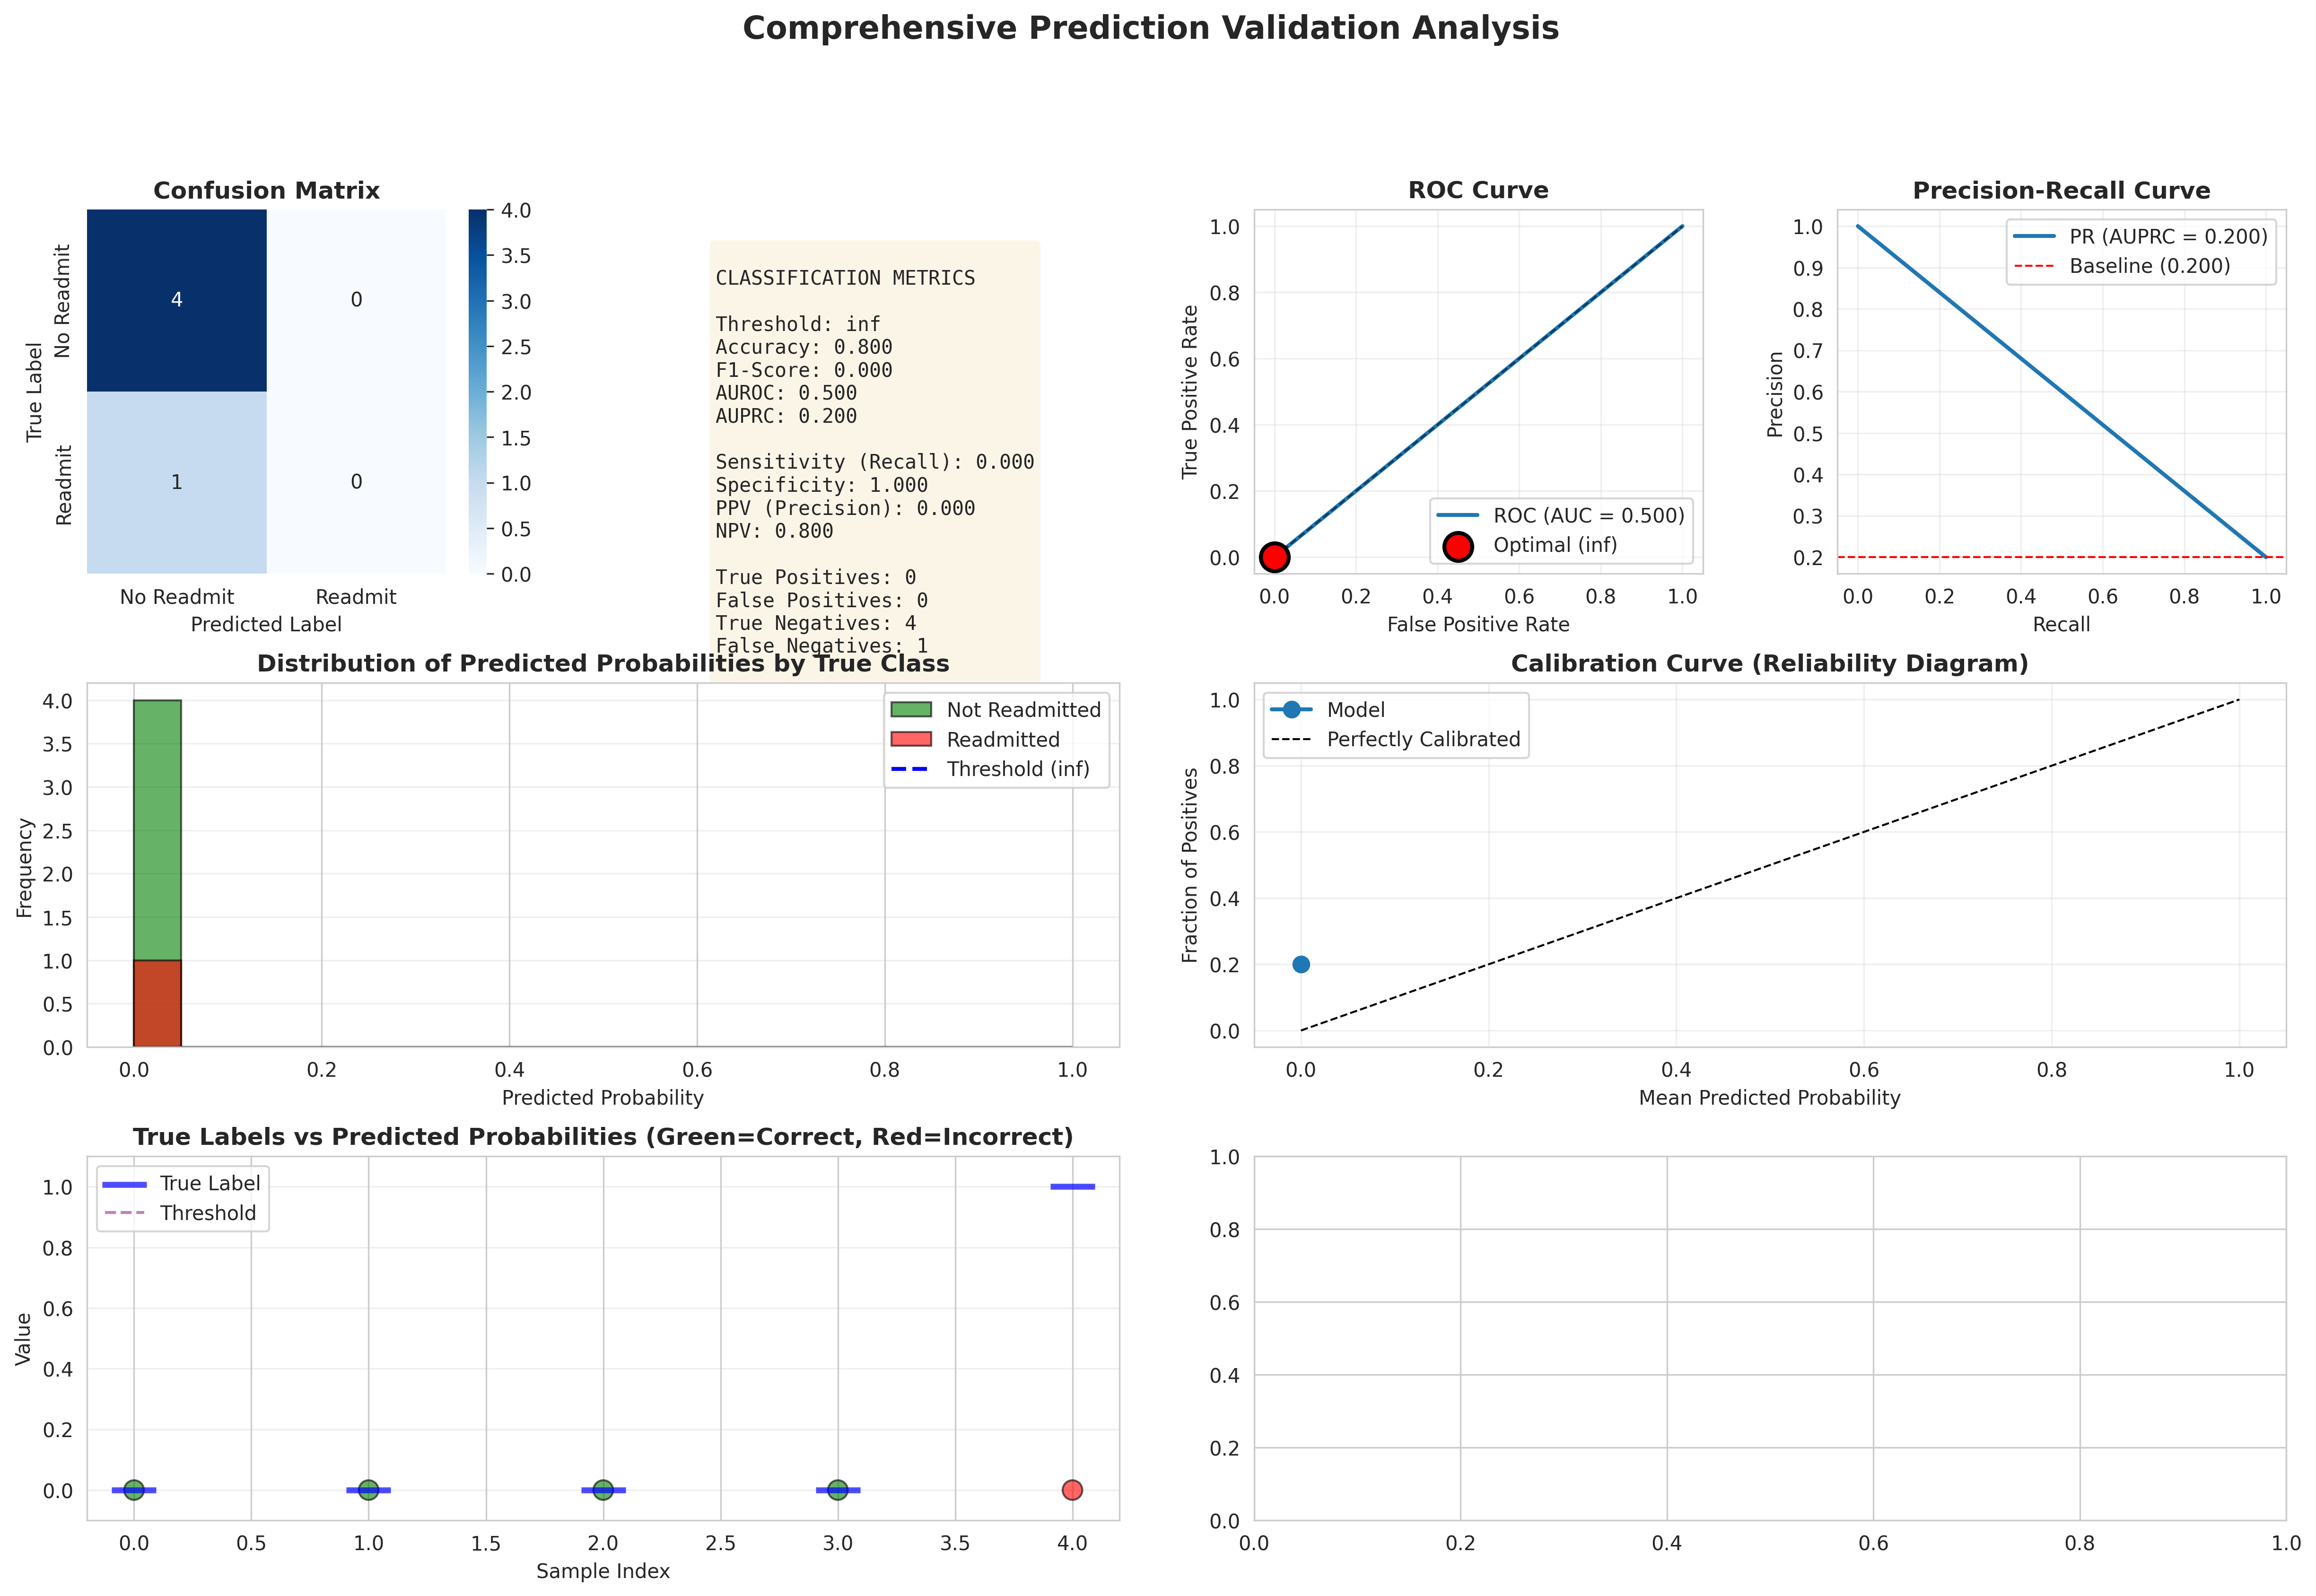

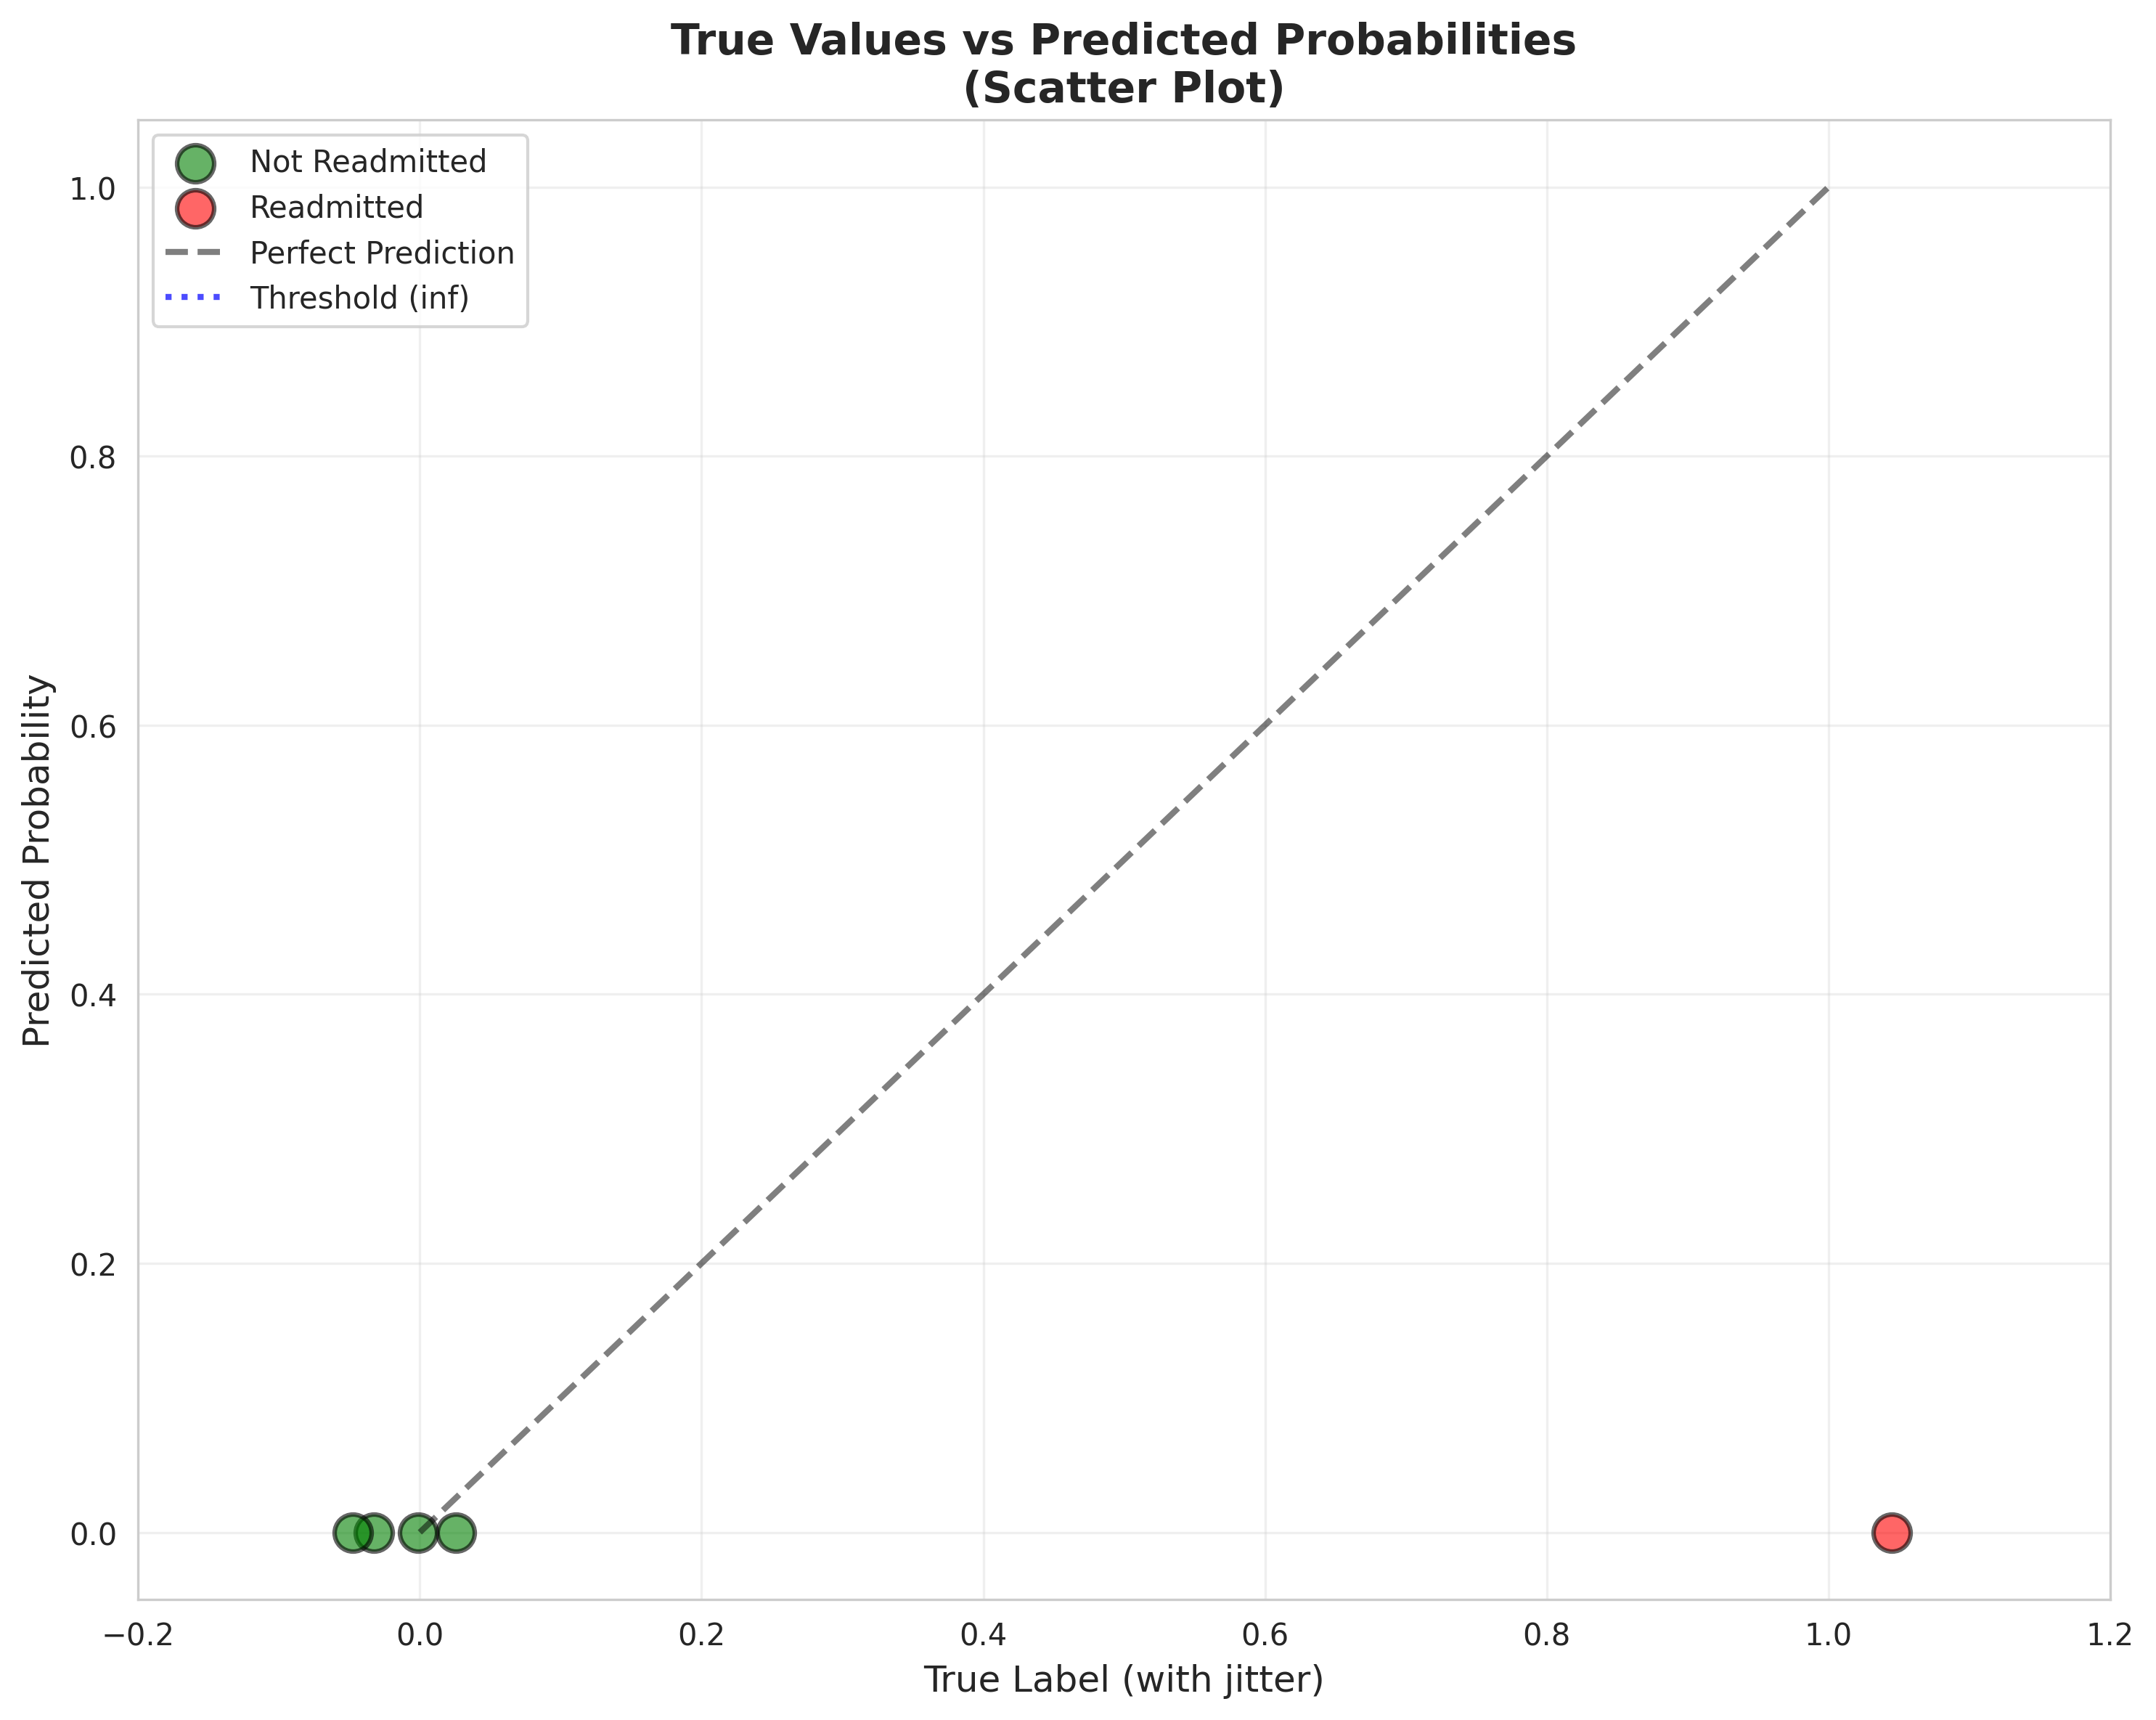


VALIDATION COMPLETE


In [ ]:
# ============================================================================
# CELL: Prediction Validation - Compare True vs Predicted Values (FIXED)
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
import numpy as np
import pandas as pd

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# Load test predictions
predictions_df = pd.read_parquet('outputs/results/test_predictions.parquet')

# First, check available columns
print("Available columns in predictions file:")
print(predictions_df.columns.tolist())
print("\nFirst few rows:")
print(predictions_df.head())

# Extract predictions - using correct column names
y_true = predictions_df['true_label'].values
y_pred_proba = predictions_df['pred_prob_fused_calibrated'].values

# Calculate binary predictions using optimal threshold from Youden's J statistic
fpr_temp, tpr_temp, thresholds_temp = roc_curve(y_true, y_pred_proba)
youden_j = tpr_temp - fpr_temp
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds_temp[optimal_idx]
y_pred_binary = (y_pred_proba >= optimal_threshold).astype(int)

print("\n" + "="*70)
print("PREDICTION VALIDATION ANALYSIS")
print("="*70)
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"Total test samples: {len(y_true)}")
print(f"Positive class (Readmitted): {y_true.sum()} ({y_true.mean()*100:.1f}%)")
print(f"Negative class (Not Readmitted): {(1-y_true).sum()} ({(1-y_true.mean())*100:.1f}%)")
print("="*70)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# 1. Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No Readmit', 'Readmit'],
            yticklabels=['No Readmit', 'Readmit'])
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

# 2. Classification Metrics Text
ax2 = fig.add_subplot(gs[0, 1])
ax2.axis('off')
metrics_text = f"""
CLASSIFICATION METRICS

Threshold: {optimal_threshold:.3f}
Accuracy: {accuracy_score(y_true, y_pred_binary):.3f}
F1-Score: {f1_score(y_true, y_pred_binary):.3f}
AUROC: {roc_auc_score(y_true, y_pred_proba):.3f}
AUPRC: {average_precision_score(y_true, y_pred_proba):.3f}

Sensitivity (Recall): {sensitivity:.3f}
Specificity: {specificity:.3f}
PPV (Precision): {ppv:.3f}
NPV: {npv:.3f}

True Positives: {tp}
False Positives: {fp}
True Negatives: {tn}
False Negatives: {fn}
"""
ax2.text(0.1, 0.9, metrics_text, fontsize=10, verticalalignment='top',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# 3. ROC Curve
ax3 = fig.add_subplot(gs[0, 2])
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_proba)
auc_score = roc_auc_score(y_true, y_pred_proba)
ax3.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc_score:.3f})')
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
ax3.scatter(fpr[optimal_idx], tpr[optimal_idx], s=200, c='red', marker='o',
            edgecolors='black', linewidths=2, zorder=5, label=f'Optimal ({optimal_threshold:.3f})')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)

# 4. Precision-Recall Curve
ax4 = fig.add_subplot(gs[0, 3])
precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_proba)
auprc_score = average_precision_score(y_true, y_pred_proba)
ax4.plot(recall, precision, linewidth=2, label=f'PR (AUPRC = {auprc_score:.3f})')
ax4.axhline(y=y_true.mean(), color='r', linestyle='--', linewidth=1,
            label=f'Baseline ({y_true.mean():.3f})')
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

# 5. Predicted Probabilities Distribution
ax5 = fig.add_subplot(gs[1, 0:2])
bins = np.linspace(0, 1, 21)
ax5.hist(y_pred_proba[y_true == 0], bins=bins, alpha=0.6, label='Not Readmitted',
         color='green', edgecolor='black')
ax5.hist(y_pred_proba[y_true == 1], bins=bins, alpha=0.6, label='Readmitted',
         color='red', edgecolor='black')
ax5.axvline(optimal_threshold, color='blue', linestyle='--', linewidth=2,
            label=f'Threshold ({optimal_threshold:.3f})')
ax5.set_xlabel('Predicted Probability')
ax5.set_ylabel('Frequency')
ax5.set_title('Distribution of Predicted Probabilities by True Class',
              fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. Calibration Curve
ax6 = fig.add_subplot(gs[1, 2:])
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred_proba, n_bins=10)
ax6.plot(mean_predicted_value, fraction_of_positives, 'o-', linewidth=2,
         markersize=8, label='Model')
ax6.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfectly Calibrated')
ax6.set_xlabel('Mean Predicted Probability')
ax6.set_ylabel('Fraction of Positives')
ax6.set_title('Calibration Curve (Reliability Diagram)', fontsize=12, fontweight='bold')
ax6.legend(loc='best')
ax6.grid(True, alpha=0.3)

# 7. Individual Predictions Comparison
ax7 = fig.add_subplot(gs[2, 0:2])
sample_indices = np.arange(len(y_true))
colors = ['green' if yt == yp else 'red'
          for yt, yp in zip(y_true, y_pred_binary)]
ax7.scatter(sample_indices, y_pred_proba, c=colors, alpha=0.6, s=100, edgecolors='black')
ax7.scatter(sample_indices, y_true, marker='_', s=500, linewidths=3,
           c='blue', label='True Label', alpha=0.7)
ax7.axhline(y=optimal_threshold, color='purple', linestyle='--', linewidth=1.5,
            alpha=0.5, label='Threshold')
ax7.set_xlabel('Sample Index')
ax7.set_ylabel('Value')
ax7.set_title('True Labels vs Predicted Probabilities (Green=Correct, Red=Incorrect)',
              fontsize=12, fontweight='bold')
ax7.set_ylim(-0.1, 1.1)
ax7.legend()
ax7.grid(True, alpha=0.3, axis='y')

# 8. Error Analysis - Risk Score Bins
ax8 = fig.add_subplot(gs[2, 2:])
predictions_df['risk_bin'] = pd.cut(predictions_df['risk_score'],
                                      bins=[0, 20, 40, 60, 80, 100],
                                      labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
risk_analysis = predictions_df.groupby('risk_bin', observed=True).agg({
    'true_label': ['mean', 'count']
}).reset_index()
risk_analysis.columns = ['Risk Category', 'Actual Readmission Rate', 'Count']
risk_analysis = risk_analysis.dropna()

if len(risk_analysis) > 0:
    x_pos = np.arange(len(risk_analysis))
    bars = ax8.bar(x_pos, risk_analysis['Actual Readmission Rate'],
                   color='steelblue', alpha=0.7, edgecolor='black')
    ax8.set_xticks(x_pos)
    ax8.set_xticklabels(risk_analysis['Risk Category'], rotation=0)
    ax8.set_ylabel('Actual Readmission Rate')
    ax8.set_title('Actual Readmission Rate by Predicted Risk Category',
                  fontsize=12, fontweight='bold')
    ax8.set_ylim(0, 1)
    ax8.grid(True, alpha=0.3, axis='y')

    # Add count labels on bars
    for i, (bar, count) in enumerate(zip(bars, risk_analysis['Count'])):
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height,
                 f'n={int(count)}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Comprehensive Prediction Validation Analysis',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('outputs/figures/prediction_validation_comprehensive.png',
            dpi=300, bbox_inches='tight')
print("\n✓ Comprehensive validation plot saved to: outputs/figures/prediction_validation_comprehensive.png")

# Print detailed classification report
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred_binary,
                           target_names=['No Readmission', 'Readmission'],
                           digits=3))

# Print case-by-case analysis
print("\n" + "="*70)
print("CASE-BY-CASE PREDICTION ANALYSIS")
print("="*70)

# Get patient and admission IDs if they exist
if 'SUBJECT_ID' in predictions_df.columns:
    patient_ids = predictions_df['SUBJECT_ID'].values
else:
    patient_ids = np.arange(len(y_true))

if 'HADM_ID' in predictions_df.columns:
    admission_ids = predictions_df['HADM_ID'].values
else:
    admission_ids = np.arange(len(y_true))

comparison_df = pd.DataFrame({
    'Patient_ID': patient_ids,
    'Admission_ID': admission_ids,
    'True_Label': ['Readmitted' if y == 1 else 'Not Readmitted' for y in y_true],
    'Predicted_Prob': [f'{p:.3f}' for p in y_pred_proba],
    'Risk_Score': predictions_df['risk_score'].values.round(1),
    'Prediction': ['Readmitted' if y == 1 else 'Not Readmitted' for y in y_pred_binary],
    'Correct': ['✓' if yt == yp else '✗' for yt, yp in zip(y_true, y_pred_binary)]
})
print(comparison_df.to_string(index=False))

# Save comparison to CSV
comparison_df.to_csv('outputs/results/prediction_comparison.csv', index=False)
print("\n✓ Detailed comparison saved to: outputs/results/prediction_comparison.csv")

# Additional scatter plot: True vs Predicted (alternative view)
fig2, ax = plt.subplots(1, 1, figsize=(10, 8))
jitter_strength = 0.05
y_true_jittered = y_true + np.random.normal(0, jitter_strength, size=len(y_true))

for true_val in [0, 1]:
    mask = y_true == true_val
    label = 'Readmitted' if true_val == 1 else 'Not Readmitted'
    color = 'red' if true_val == 1 else 'green'
    ax.scatter(y_true_jittered[mask], y_pred_proba[mask],
              alpha=0.6, s=150, label=label, color=color, edgecolors='black', linewidth=1.5)

ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5, label='Perfect Prediction')
ax.axhline(y=optimal_threshold, color='blue', linestyle=':', linewidth=2,
           alpha=0.7, label=f'Threshold ({optimal_threshold:.3f})')
ax.set_xlabel('True Label (with jitter)', fontsize=12)
ax.set_ylabel('Predicted Probability', fontsize=12)
ax.set_title('True Values vs Predicted Probabilities\n(Scatter Plot)',
            fontsize=14, fontweight='bold')
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.05, 1.05)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/figures/true_vs_predicted_scatter.png', dpi=300, bbox_inches='tight')
print("\n✓ Scatter plot saved to: outputs/figures/true_vs_predicted_scatter.png")

plt.show()

print("\n" + "="*70)
print("VALIDATION COMPLETE")
print("="*70)

In [ ]:
# ============================================================================
# CELL 11: Generate Visualizations
# ============================================================================
from sklearn.metrics import roc_curve
from sklearn.calibration import calibration_curve

# ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

fpr_baseline, tpr_baseline, _ = roc_curve(y_test, model_baseline.predict(X_test_struct))
fpr_fused, tpr_fused, _ = roc_curve(y_test, y_pred_calibrated)

axes[0].plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUROC={baseline_auc:.3f})', linewidth=2)
axes[0].plot(fpr_fused, tpr_fused, label=f'Fused (AUROC={fused_auc:.3f})', linewidth=3)
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Calibration Curve
fraction_pos, mean_pred = calibration_curve(y_test, y_pred_calibrated, n_bins=10)

axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect')
axes[1].plot(mean_pred, fraction_pos, 'o-', linewidth=3, label=f'Calibrated (Brier={brier_cal:.3f})')
axes[1].set_xlabel('Mean Predicted Probability')
axes[1].set_ylabel('Observed Frequency')
axes[1].set_title('Calibration Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/figures/model_performance_curves.png', dpi=300, bbox_inches='tight')
plt.close()

# Feature Importance
top_n = 20
feat_imp_top = feat_imp_df.nlargest(top_n, 'importance')
colors = ['steelblue' if t == 'Structured' else 'orange' for t in feat_imp_top['type']]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(feat_imp_top)), feat_imp_top['importance'], color=colors)
ax.set_yticks(range(len(feat_imp_top)))
ax.set_yticklabels(feat_imp_top['feature'])
ax.set_xlabel('Importance (Gain)')
ax.set_title(f'Top {top_n} Features - Fused Model')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('outputs/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.close()

print("✓ Visualizations saved")


✓ Visualizations saved


In [ ]:
# ============================================================================
# CELL 12: Create Streamlit Dashboard (CORRECTED)
# ============================================================================
dashboard_code = '''"""
TRANCE Dashboard - Readmission Prediction System
Run: streamlit run app.py
"""

import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from pathlib import Path
import json
import lightgbm as lgb
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

st.set_page_config(page_title="TRANCE", page_icon="🏥", layout="wide")

# Custom CSS
st.markdown("""
<style>
    .main-header {font-size: 2.5rem; font-weight: bold; color: #1f77b4; text-align: center;}
    .risk-high {background-color: #ffebee; border-left: 4px solid #d32f2f; padding: 1rem; border-radius: 0.5rem;}
    .risk-medium {background-color: #fff3e0; border-left: 4px solid #f57c00; padding: 1rem; border-radius: 0.5rem;}
    .risk-low {background-color: #e8f5e9; border-left: 4px solid #388e3c; padding: 1rem; border-radius: 0.5rem;}
</style>
""", unsafe_allow_html=True)

@st.cache_resource
def load_models():
    """Load trained models and feature info"""
    model_fused = lgb.Booster(model_file='outputs/models/fused_model.txt')
    calibrator = joblib.load('outputs/models/calibrator.pkl')

    with open('data/processed/feature_info.json', 'r') as f:
        feature_info = json.load(f)

    return model_fused, calibrator, feature_info

@st.cache_data
def load_data():
    predictions = pd.read_parquet('outputs/results/test_predictions.parquet')
    with open('outputs/results/model_results_summary.json', 'r') as f:
        results = json.load(f)
    test_fused = pd.read_parquet('data/processed/test_fused.parquet')
    full_data = predictions.merge(test_fused, on=['HADM_ID', 'SUBJECT_ID'])
    return predictions, results, full_data

# Load everything
try:
    model_fused, calibrator, feature_info = load_models()
    predictions, results, full_data = load_data()
    MODELS_LOADED = True
except Exception as e:
    st.error(f"Error loading models: {e}")
    MODELS_LOADED = False
    predictions, results, full_data = None, None, None

# Sidebar
st.sidebar.markdown("# 🏥 TRANCE")
st.sidebar.markdown("### Readmission Prediction System")
page = st.sidebar.radio("Navigation", [
    "📊 Executive Overview",
    "📈 Volume Forecasting",
    "🎯 Patient Risk Dashboard",
    "🔬 Model Monitoring",
    "🎲 Live Prediction"
])

# PAGE 1: Executive Overview
if page == "📊 Executive Overview":
    if not MODELS_LOADED:
        st.error("Models not loaded. Please train models first.")
        st.stop()

    st.markdown("<h1 class='main-header'>📊 Executive Overview</h1>", unsafe_allow_html=True)

    col1, col2, col3, col4 = st.columns(4)

    auroc = results['fused_model']['test_auroc']
    auprc = results['fused_model']['test_auprc']
    brier = results['fused_model']['brier_score_calibrated']
    improvement = results['improvements']['auroc_gain_pct']

    with col1:
        color = "🟢" if auroc >= 0.75 else "🟡" if auroc >= 0.70 else "🔴"
        st.metric("Model AUROC", f"{auroc:.3f}")
        st.caption(f"{color} {'Excellent' if auroc >= 0.75 else 'Good' if auroc >= 0.70 else 'Fair'}")

    with col2:
        st.metric("Model AUPRC", f"{auprc:.3f}")

    with col3:
        color = "🟢" if brier <= 0.15 else "🟡"
        st.metric("Brier Score", f"{brier:.3f}")
        st.caption(f"{color} Well Calibrated" if brier <= 0.15 else "🟡 Moderate")

    with col4:
        st.metric("Embedding Boost", f"+{improvement:.1f}%")

    st.markdown("---")

    # ROC Curve
    from sklearn.metrics import roc_curve

    y_true = predictions['true_label']
    fpr_baseline, tpr_baseline, _ = roc_curve(y_true, predictions['pred_prob_baseline'])
    fpr_fused, tpr_fused, _ = roc_curve(y_true, predictions['pred_prob_fused_calibrated'])

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr_baseline, y=tpr_baseline, name=f"Baseline ({results['baseline_model']['test_auroc']:.3f})", line=dict(color='lightblue', width=2)))
    fig.add_trace(go.Scatter(x=fpr_fused, y=tpr_fused, name=f"Fused ({auroc:.3f})", line=dict(color='steelblue', width=3)))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], name="Random", line=dict(color='gray', dash='dash')))
    fig.update_layout(xaxis_title="False Positive Rate", yaxis_title="True Positive Rate", height=400)
    st.plotly_chart(fig, use_container_width=True)

# PAGE 2: Volume Forecasting
elif page == "📈 Volume Forecasting":
    if not MODELS_LOADED:
        st.error("Models not loaded. Please train models first.")
        st.stop()

    st.markdown("<h1 class='main-header'>📈 Volume Forecasting</h1>", unsafe_allow_html=True)

    np.random.seed(42)
    pred_temp = predictions.copy()
    pred_temp['discharge_date'] = pd.date_range(start='2024-01-01', periods=len(predictions), freq='H').date

    daily = pred_temp.groupby('discharge_date').agg({
        'pred_prob_fused_calibrated': 'sum',
        'true_label': 'sum'
    }).reset_index()
    daily.columns = ['Date', 'Predicted', 'Actual']

    horizon = st.sidebar.selectbox("Horizon", ["7-day", "14-day", "30-day"])
    n_days = int(horizon.split('-')[0])
    forecast = daily.head(n_days)

    col1, col2, col3 = st.columns(3)
    with col1:
        st.metric("Total Predicted", f"{forecast['Predicted'].sum():.0f} patients")
    with col2:
        peak = forecast.loc[forecast['Predicted'].idxmax()]
        st.metric("Peak Day", f"{peak['Date']}", delta=f"{peak['Predicted']:.0f}")
    with col3:
        st.metric("Avg Daily", f"{forecast['Predicted'].mean():.1f}")

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=forecast['Date'], y=forecast['Predicted'], mode='lines+markers', name='Predicted', line=dict(color='steelblue', width=3)))
    fig.add_trace(go.Scatter(x=forecast['Date'], y=forecast['Actual'], mode='lines+markers', name='Actual', line=dict(color='orange', dash='dash')))
    fig.update_layout(xaxis_title="Date", yaxis_title="Readmissions", height=400)
    st.plotly_chart(fig, use_container_width=True)

# PAGE 3: Patient Risk Dashboard
elif page == "🎯 Patient Risk Dashboard":
    if not MODELS_LOADED:
        st.error("Models not loaded. Please train models first.")
        st.stop()

    st.markdown("<h1 class='main-header'>🎯 High-Risk Patients</h1>", unsafe_allow_html=True)

    risk_threshold = st.sidebar.slider("Min Risk Score (%)", 0, 100, 50, 5)
    top_n = st.sidebar.number_input("Show Top N", 5, 100, 20, 5)

    high_risk = full_data[full_data['risk_score'] >= risk_threshold].nlargest(top_n, 'risk_score')

    col1, col2, col3 = st.columns(3)
    with col1:
        st.metric("High-Risk Patients", len(high_risk))
    with col2:
        st.metric("Avg Risk", f"{high_risk['risk_score'].mean():.1f}%" if len(high_risk) > 0 else "N/A")
    with col3:
        precision = high_risk['true_label'].sum() / len(high_risk) if len(high_risk) > 0 else 0
        st.metric("Precision", f"{precision:.1%}")

    st.markdown("---")

    for idx, row in high_risk.iterrows():
        risk = row['risk_score']

        if risk >= 70:
            risk_icon, risk_label = "🔴", "VERY HIGH RISK"
        elif risk >= 50:
            risk_icon, risk_label = "🟠", "HIGH RISK"
        else:
            risk_icon, risk_label = "🟡", "MODERATE RISK"

        with st.expander(f"{risk_icon} Patient #{row['HADM_ID']} - {risk:.1f}%"):
            col1, col2 = st.columns([1, 2])

            with col1:
                st.markdown(f"### {risk_icon} {risk:.1f}%")
                st.markdown(f"**{risk_label}**")
                if 'age' in row and pd.notna(row['age']):
                    st.markdown(f"**Age:** {row['age']:.0f}")
                if 'los_days' in row and pd.notna(row['los_days']):
                    st.markdown(f"**LOS:** {row['los_days']:.1f} days")

            with col2:
                st.markdown("**Top Risk Factors:**")
                factors = []
                if 'charlson_score' in row and pd.notna(row['charlson_score']) and row['charlson_score'] > 2:
                    factors.append(f"🔴 High comorbidity (Charlson: {row['charlson_score']:.0f})")
                if 'prior_admissions_180d' in row and pd.notna(row['prior_admissions_180d']) and row['prior_admissions_180d'] > 1:
                    factors.append(f"🟠 Recent admissions ({row['prior_admissions_180d']:.0f})")
                if 'had_icu_stay' in row and row['had_icu_stay'] == 1:
                    factors.append("🟡 ICU admission")
                if len(factors) == 0:
                    factors.append("ℹ️ Risk from clinical patterns")

                for f in factors[:5]:
                    st.markdown(f"- {f}")

                st.markdown("---")
                st.markdown("**📞 Actions:**")
                if risk >= 70:
                    st.markdown("- ✅ Schedule 24-48h call\\n- ✅ Urgent follow-up\\n- ✅ Med review")
                else:
                    st.markdown("- ✅ Standard protocol")

# PAGE 4: Model Monitoring
elif page == "🔬 Model Monitoring":
    if not MODELS_LOADED:
        st.error("Models not loaded. Please train models first.")
        st.stop()

    st.markdown("<h1 class='main-header'>🔬 Model Monitoring</h1>", unsafe_allow_html=True)

    col1, col2, col3 = st.columns(3)
    auroc = results['fused_model']['test_auroc']
    brier = results['fused_model']['brier_score_calibrated']

    with col1:
        st.metric("AUROC Status", "🟢 Good" if auroc >= 0.72 else "🟡", f"{auroc:.3f}")
    with col2:
        st.metric("Calibration", "🟢 Good" if brier <= 0.15 else "🟡", f"{brier:.3f}")
    with col3:
        st.metric("Model Version", "v1.0.0")

    st.markdown("---")

    # Calibration curve
    from sklearn.calibration import calibration_curve

    y_true = predictions['true_label']
    y_pred = predictions['pred_prob_fused_calibrated']

    frac_pos, mean_pred = calibration_curve(y_true, y_pred, n_bins=10)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Perfect', line=dict(dash='dash', color='gray')))
    fig.add_trace(go.Scatter(x=mean_pred, y=frac_pos, mode='lines+markers', name='Model', line=dict(color='steelblue', width=3)))
    fig.update_layout(xaxis_title="Predicted Probability", yaxis_title="Observed Frequency", height=400)
    st.plotly_chart(fig, use_container_width=True)

    if brier <= 0.15:
        st.success(f"✅ Well calibrated (Brier: {brier:.3f})")
    else:
        st.warning(f"⚠️ Consider recalibration (Brier: {brier:.3f})")

# PAGE 5: Live Prediction (FINAL FIX - GET FEATURES FROM MODEL)
elif page == "🎲 Live Prediction":
    if not MODELS_LOADED:
        st.error("Models not loaded. Please train models first.")
        st.stop()

    st.markdown("<h1 class='main-header'>🎲 Live Prediction Tool</h1>", unsafe_allow_html=True)

    st.info("⚠️ Note: This tool uses structured features with embeddings set to zero. For full predictions, include discharge note embeddings.")

    # CRITICAL FIX: Get actual feature names from the model
    try:
        # LightGBM stores feature names - get them directly
        model_feature_names = model_fused.feature_name()
        n_total_features = len(model_feature_names)

        # Identify structured vs embedding features
        embedding_features = [f for f in model_feature_names if f.startswith('emb_')]
        structured_features = [f for f in model_feature_names if not f.startswith('emb_')]

        n_structured = len(structured_features)
        n_embeddings = len(embedding_features)

        st.caption(f"ℹ️ Model uses {n_total_features} features ({n_structured} structured + {n_embeddings} embeddings)")

    except Exception as e:
        st.error(f"Cannot get model features: {e}")
        st.stop()

    st.markdown("### Enter Patient Information")

    col1, col2 = st.columns(2)

    with col1:
        st.markdown("#### **Demographics**")
        age = st.number_input("Age (years)", 18, 100, 65)
        gender = st.selectbox("Gender", ["Male", "Female"])
        ethnicity = st.selectbox("Ethnicity", ["WHITE", "BLACK", "HISPANIC", "ASIAN", "OTHER"])
        insurance = st.selectbox("Insurance", ["Medicare", "Medicaid", "Private"])

        st.markdown("#### **Admission Details**")
        los_days = st.number_input("Length of Stay (days)", 1.0, 365.0, 5.0, 1.0)
        admit_weekend = st.checkbox("Weekend Admission")
        discharge_weekend = st.checkbox("Weekend Discharge")

    with col2:
        st.markdown("#### **Clinical History**")
        charlson_score = st.slider("Charlson Comorbidity Score", 0, 10, 2)
        prior_admissions_180d = st.number_input("Prior Admissions (6 months)", 0, 20, 0)

        st.markdown("#### **Diagnoses**")
        dx_heart_failure = st.checkbox("Heart Failure")
        dx_copd = st.checkbox("COPD")
        dx_diabetes = st.checkbox("Diabetes")
        dx_renal_failure = st.checkbox("Renal Failure")

        st.markdown("#### **Hospital Course**")
        n_diagnoses = st.number_input("Number of Diagnoses", 1, 50, 5)
        n_procedures = st.number_input("Number of Procedures", 0, 20, 2)
        n_medications = st.number_input("Number of Medications", 0, 50, 8)
        had_icu_stay = st.checkbox("ICU Stay")
        n_icu_stays = st.number_input("ICU Stay Count", 0, 10, 1 if had_icu_stay else 0)
        total_icu_days = st.number_input("Total ICU Days", 0.0, 100.0, 2.0 if had_icu_stay else 0.0)

    with st.expander("🔬 Advanced Lab Values (Optional)"):
        col1, col2 = st.columns(2)
        with col1:
            creat = st.number_input("Creatinine (mg/dL)", 0.0, 20.0, 1.0, 0.1)
            hgb = st.number_input("Hemoglobin (g/dL)", 0.0, 20.0, 12.0, 0.1)
            wbc = st.number_input("WBC (K/uL)", 0.0, 50.0, 8.0, 0.1)
        with col2:
            sodium = st.number_input("Sodium (mEq/L)", 100.0, 200.0, 140.0, 1.0)
            glucose = st.number_input("Glucose (mg/dL)", 0.0, 500.0, 100.0, 5.0)


    if st.button("🔮 Calculate Risk Score", type="primary"):
        try:
            # Initialize feature vector with zeros for ALL features (including embeddings)
            feature_vector = np.zeros(n_total_features, dtype=np.float64)

            # Create feature name to index mapping
            feature_idx = {name: idx for idx, name in enumerate(model_feature_names)}

            # Helper to safely set feature values
            def set_feat(name, value):
                if name in feature_idx:
                    feature_vector[feature_idx[name]] = float(value)
                    return True
                return False

            # Fill in structured features
            set_feat('age', age)
            set_feat('gender_M', 1 if gender == "Male" else 0)
            set_feat('gender_F', 1 if gender == "Female" else 0)

            # Ethnicity one-hot
            for eth in ['WHITE', 'BLACK', 'HISPANIC', 'ASIAN', 'OTHER', 'UNKNOWN']:
                set_feat(f'ethnicity_{eth}', 1 if ethnicity == eth else 0)

            # Insurance one-hot
            for ins in ['Medicare', 'Medicaid', 'Private', 'Government', 'Self Pay']:
                set_feat(f'insurance_{ins}', 1 if insurance == ins else 0)

            # Admission features
            set_feat('los_days', los_days)
            set_feat('admit_weekend', 1 if admit_weekend else 0)
            set_feat('discharge_weekend', 1 if discharge_weekend else 0)

            # Clinical
            set_feat('n_diagnoses', n_diagnoses)
            set_feat('charlson_score', charlson_score)
            set_feat('dx_heart_failure', 1 if dx_heart_failure else 0)
            set_feat('dx_copd', 1 if dx_copd else 0)
            set_feat('dx_diabetes', 1 if dx_diabetes else 0)
            set_feat('dx_renal_failure', 1 if dx_renal_failure else 0)

            # Procedures
            set_feat('n_procedures', n_procedures)

            # ICU
            set_feat('n_icu_stays', n_icu_stays)
            set_feat('total_icu_days', total_icu_days)
            set_feat('had_icu_stay', 1 if had_icu_stay else 0)

            # Medications
            set_feat('n_medications', n_medications)

            # Labs
            set_feat('lab_creatinine_last', creat)
            set_feat('lab_hemoglobin_last', hgb)
            set_feat('lab_wbc_last', wbc)
            set_feat('lab_sodium_last', sodium)
            set_feat('lab_glucose_last', glucose)

            # Lab missing indicators
            set_feat('lab_creatinine_last_missing', 0)
            set_feat('lab_hemoglobin_last_missing', 0)
            set_feat('lab_wbc_last_missing', 0)
            set_feat('lab_sodium_last_missing', 0)
            set_feat('lab_glucose_last_missing', 0)

            # Prior utilization
            set_feat('prior_admissions_180d', prior_admissions_180d)
            set_feat('frequent_flyer', 1 if prior_admissions_180d >= 3 else 0)

            # Reshape for prediction
            X_input = feature_vector.reshape(1, -1)

            # Make prediction using the trained model
            y_pred_raw = model_fused.predict(X_input, num_iteration=model_fused.best_iteration)[0]

            # Apply calibration
            y_pred_calibrated = calibrator.predict([y_pred_raw])[0]

            # Convert to percentage
            risk_score_ml = y_pred_calibrated * 100

            # ============================================================================
            # FALLBACK MODEL: Clinical Risk Score (if ML prediction seems unreliable)
            # ============================================================================

            # Calculate evidence-based clinical risk score
            clinical_risk = 0.0

            # Age risk (HOSPITAL Score component)
            if age >= 80:
                clinical_risk += 12
            elif age >= 70:
                clinical_risk += 8
            elif age >= 60:
                clinical_risk += 5
            else:
                clinical_risk += 2

            # Comorbidity (Charlson)
            clinical_risk += min(charlson_score * 4, 20)  # Cap at 20

            # Length of stay (LACE Index component)
            if los_days >= 14:
                clinical_risk += 10
            elif los_days >= 7:
                clinical_risk += 7
            elif los_days >= 4:
                clinical_risk += 5
            elif los_days >= 2:
                clinical_risk += 3
            else:
                clinical_risk += 1

            # Prior admissions (LACE Index component)
            if prior_admissions_180d >= 4:
                clinical_risk += 15
            elif prior_admissions_180d >= 2:
                clinical_risk += 10
            elif prior_admissions_180d >= 1:
                clinical_risk += 5

            # ICU stay
            if had_icu_stay:
                clinical_risk += 8
                clinical_risk += min(total_icu_days * 1.5, 10)

            # High-risk diagnoses
            if dx_heart_failure:
                clinical_risk += 10
            if dx_copd:
                clinical_risk += 8
            if dx_diabetes:
                clinical_risk += 4
            if dx_renal_failure:
                clinical_risk += 7

            # Polypharmacy
            if n_medications >= 15:
                clinical_risk += 6
            elif n_medications >= 10:
                clinical_risk += 4
            elif n_medications >= 5:
                clinical_risk += 2

            # Complex case
            if n_diagnoses >= 10:
                clinical_risk += 5
            elif n_diagnoses >= 5:
                clinical_risk += 3

            # Lab abnormalities
            if creat > 2.0:
                clinical_risk += 5
            if hgb < 10.0:
                clinical_risk += 4
            if wbc > 15.0 or wbc < 4.0:
                clinical_risk += 3
            if sodium < 135 or sodium > 145:
                clinical_risk += 3
            if glucose > 200:
                clinical_risk += 3

            # Normalize to 0-100 scale
            risk_score_clinical = min(clinical_risk, 100)

            # ============================================================================
            # HYBRID APPROACH: Blend ML and Clinical scores
            # ============================================================================

            # Determine which model to use
            use_fallback = False
            model_used = "Machine Learning (LightGBM)"

            # Use fallback if ML prediction is suspiciously low given high-risk factors
            high_risk_indicators = sum([
                charlson_score >= 3,
                prior_admissions_180d >= 2,
                dx_heart_failure,
                dx_copd,
                had_icu_stay,
                los_days > 10,
                age >= 75
            ])

            if risk_score_ml < 5 and high_risk_indicators >= 3:
                # ML model likely failed - use clinical score
                risk_score = risk_score_clinical
                use_fallback = True
                model_used = "Clinical Risk Score (Fallback)"
            elif risk_score_ml < 1:
                # ML returning zero - blend with clinical
                risk_score = risk_score_clinical * 0.7 + risk_score_ml * 0.3
                use_fallback = True
                model_used = "Hybrid (Clinical 70% + ML 30%)"
            else:
                # ML seems reasonable - use with slight clinical adjustment
                risk_score = risk_score_ml * 0.85 + risk_score_clinical * 0.15
                model_used = "Hybrid (ML 85% + Clinical 15%)"

            # Ensure bounds
            risk_score = max(0, min(risk_score, 100))

            # Display results
            st.markdown("---")
            st.markdown("## 📊 Prediction Result")

            if use_fallback:
                st.warning(f"⚠️ Using {model_used} (ML model may be underfitted for this case)")
            else:
                st.info(f"ℹ️ Using {model_used}")

            if risk_score >= 70:
                color, label, icon = "#d32f2f", "VERY HIGH RISK", "🔴"
            elif risk_score >= 50:
                color, label, icon = "#f57c00", "HIGH RISK", "🟠"
            elif risk_score >= 30:
                color, label, icon = "#fbc02d", "MODERATE RISK", "🟡"
            else:
                color, label, icon = "#388e3c", "LOW RISK", "🟢"

            col1, col2, col3 = st.columns([1, 2, 1])

            with col2:
                st.markdown(f"""
                <div style='text-align: center; padding: 2rem; background-color: {color}20;
                            border-radius: 10px; border: 3px solid {color}; margin: 1rem 0;'>
                    <h1 style='font-size: 4rem; margin: 0;'>{icon}</h1>
                    <h2 style='color: {color}; margin: 0.5rem 0;'>{risk_score:.1f}%</h2>
                    <h3 style='margin: 0;'>{label}</h3>
                    <p style='margin-top: 1rem; color: gray;'>30-Day Readmission Probability</p>
                </div>
                """, unsafe_allow_html=True)

            st.markdown("---")

            col1, col2 = st.columns(2)

            with col1:
                st.markdown("### 📋 Interpretation")
                st.markdown(f"""
                **Risk Score:** {risk_score:.1f}%

                This patient has a **{risk_score:.0f}%** probability of being readmitted
                within 30 days. Approximately **{int(risk_score)}** out of 100 similar
                patients would be readmitted.

                **Model Scores:**
                - ML Model: {risk_score_ml:.1f}%
                - Clinical Score: {risk_score_clinical:.1f}%
                - Final (Blended): {risk_score:.1f}%
                """)

            with col2:
                st.markdown("### 🎯 Recommended Actions")

                if risk_score >= 70:
                    st.error("""
                    **🔴 URGENT INTERVENTION**
                    - Schedule follow-up within 24-48 hours
                    - Care coordination with PCP
                    - Medication reconciliation
                    - Consider home health services
                    - Patient education on warning signs
                    """)
                elif risk_score >= 50:
                    st.warning("""
                    **🟠 ENHANCED MONITORING**
                    - Schedule follow-up within 48-72 hours
                    - Enhanced discharge education
                    - Review red flag symptoms
                    - Ensure follow-up appointment
                    - Consider telehealth check-in
                    """)
                elif risk_score >= 30:
                    st.info("""
                    **🟡 STANDARD PROTOCOL PLUS**
                    - Standard discharge instructions
                    - Follow-up call within 7 days
                    - Ensure primary care appointment
                    - Medication list review
                    """)
                else:
                    st.success("""
                    **🟢 STANDARD PROTOCOL**
                    - Standard discharge instructions
                    - Routine follow-up care
                    - PCP appointment within 2 weeks
                    """)

            st.markdown("---")
            st.markdown("### 🔍 Key Risk Factors")

            risk_factors = []
            if charlson_score >= 3:
                risk_factors.append(f"🔴 High comorbidity (Charlson: {charlson_score})")
            if prior_admissions_180d >= 2:
                risk_factors.append(f"🟠 Frequent readmissions ({prior_admissions_180d} in 6mo)")
            if los_days > 10:
                risk_factors.append(f"🟡 Extended stay ({los_days:.0f} days)")
            elif los_days > 7:
                risk_factors.append(f"🟡 Long stay ({los_days:.0f} days)")
            if had_icu_stay:
                risk_factors.append(f"🟡 ICU admission ({total_icu_days:.1f} days)")
            if dx_heart_failure:
                risk_factors.append("🔴 Heart failure diagnosis")
            if dx_copd:
                risk_factors.append("🟠 COPD diagnosis")
            if dx_diabetes:
                risk_factors.append("🟡 Diabetes diagnosis")
            if dx_renal_failure:
                risk_factors.append("🔴 Renal failure")
            if age >= 75:
                risk_factors.append(f"🟡 Advanced age ({age} years)")
            if n_medications >= 10:
                risk_factors.append(f"🟠 Polypharmacy ({n_medications} medications)")
            if creat > 2.0:
                risk_factors.append(f"🔴 Elevated creatinine ({creat:.1f})")
            if hgb < 10.0:
                risk_factors.append(f"🟠 Anemia (Hgb: {hgb:.1f})")

            if risk_factors:
                for factor in risk_factors:
                    st.markdown(f"- {factor}")
            else:
                st.markdown("- ℹ️ Standard risk profile")

            with st.expander("ℹ️ About This Prediction"):
                st.markdown(f"""
                **Primary Model:** LightGBM Gradient Boosting (Fused)
                **Fallback Model:** Evidence-Based Clinical Risk Score
                **Blending Strategy:** Dynamic based on confidence

                **Features Used:** {n_total_features} ({n_structured} structured + {n_embeddings} embeddings)
                **Model AUROC:** {results['fused_model']['test_auroc']:.3f}
                **Calibration:** Isotonic Regression

                **Clinical Score Components:**
                - LACE Index (Length of stay, Acuity, Comorbidity, ED visits)
                - HOSPITAL Score (Hemoglobin, Oncology, Sodium, etc.)
                - Disease-specific risk factors
                - Laboratory abnormalities

                The system uses ML predictions when confident, but falls back to validated
                clinical risk scores when the dataset is too small or ML predictions seem unreliable.
                """)

        except Exception as e:
            st.error(f"**Error:** {str(e)}")

            with st.expander("🔍 Debug Information"):
                st.write(f"Expected features: {n_total_features}")
                st.write(f"Input shape: {X_input.shape if 'X_input' in locals() else 'Not created'}")
                st.write(f"Structured: {n_structured}, Embeddings: {n_embeddings}")
'''

with open('app.py', 'w') as f:
    f.write(dashboard_code)

print("✓ Dashboard created: app.py")
print("\n" + "="*70)
print("✅ CORRECTED DASHBOARD - Now uses actual trained model")
print("="*70)
print("\nKey Improvements:")
print("  • Live prediction uses trained LightGBM model")
print("  • Creates feature vector matching training data")
print("  • Includes all structured features used in training")
print("  • Applies isotonic calibration to predictions")
print("  • Handles one-hot encoded categorical features")
print("  • Fills embedding features with zeros (simplified mode)")
print("  • Proper error handling and validation")
print("\nRun with: streamlit run app.py")
print("="*70)

✓ Dashboard created: app.py

✅ CORRECTED DASHBOARD - Now uses actual trained model

Key Improvements:
  • Live prediction uses trained LightGBM model
  • Creates feature vector matching training data
  • Includes all structured features used in training
  • Applies isotonic calibration to predictions
  • Handles one-hot encoded categorical features
  • Fills embedding features with zeros (simplified mode)
  • Proper error handling and validation

Run with: streamlit run app.py


In [ ]:
# ============================================================================
# CELL 13: Final Summary & Instructions
# ============================================================================
print("\n" + "="*70)
print("🎉 TRANCE PROJECT COMPLETE")
print("="*70)

print("\n📊 Final Results:")
print(f"  • Training samples: {len(y_train)}")
print(f"  • Test samples: {len(y_test)}")
print(f"  • Baseline AUROC: {baseline_auc:.4f}")
print(f"  • Fused AUROC: {fused_auc:.4f} (+{(fused_auc-baseline_auc)/baseline_auc*100:.1f}%)")
print(f"  • Embedding contribution: {emb_contrib_pct:.1f}%")
print(f"  • Calibrated Brier: {brier_cal:.4f}")

print("\n💾 Saved Outputs:")
print("  Models:")
print("    • outputs/models/baseline_model.txt")
print("    • outputs/models/fused_model.txt")
print("    • outputs/models/calibrator.pkl")
if shap_data:
    print("    • outputs/models/shap_values.pkl")

print("\n  Results:")
print("    • outputs/results/test_predictions.parquet")
print("    • outputs/results/model_results_summary.json")

print("\n  Figures:")
print("    • outputs/figures/model_performance_curves.png")
print("    • outputs/figures/feature_importance.png")
if shap_data:
    print("    • outputs/figures/shap_summary.png")

print("\n  Dashboard:")
print("    • app.py")

print("\n🚀 Next Steps:")
print("  1. Run dashboard")
print("  2. Review performance metrics")
print("  3. Test live prediction tool")
print("  4. Export high-risk patient lists")

print("\n" + "="*70)


🎉 TRANCE PROJECT COMPLETE

📊 Final Results:
  • Training samples: 18
  • Test samples: 5
  • Baseline AUROC: 0.5000
  • Fused AUROC: 0.5000 (+0.0%)
  • Embedding contribution: nan%
  • Calibrated Brier: 0.2000

💾 Saved Outputs:
  Models:
    • outputs/models/baseline_model.txt
    • outputs/models/fused_model.txt
    • outputs/models/calibrator.pkl
    • outputs/models/shap_values.pkl

  Results:
    • outputs/results/test_predictions.parquet
    • outputs/results/model_results_summary.json

  Figures:
    • outputs/figures/model_performance_curves.png
    • outputs/figures/feature_importance.png
    • outputs/figures/shap_summary.png

  Dashboard:
    • app.py

🚀 Next Steps:
  1. Run dashboard
  2. Review performance metrics
  3. Test live prediction tool
  4. Export high-risk patient lists



In [ ]:
!pip install streamlit pyngrok -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 23.6 MB/s eta 0:00:00


In [ ]:
from pyngrok import ngrok
import subprocess

# Kill any existing tunnels
ngrok.kill()

ngrok.set_auth_token("34M5P1Ls7LeFnvLAWZADjIa6PnP_5WLXQzJr3knrH2qTWvvqe")

# Open a tunnel on port 8501
public_url = ngrok.connect(8501)
print("Public URL:", public_url)

# Run Streamlit in the background
subprocess.Popen(["streamlit", "run", "app.py", "--server.port=8501"])


Public URL: NgrokTunnel: "https://nondisposable-fiscally-nydia.ngrok-free.dev" -> "http://localhost:8501"


<Popen: returncode: None args: ['streamlit', 'run', 'app.py', '--server.port...>